# AI for Earth System Science Hackathon 2020
# GOES Challenge
David John Gagne, Gunther Wallach, Charlie Becker, Bill Petzke

## Introduction
![GOES-R satellite image from Wikipedia](goes_images/GOES-R_SPACECRAFT.jpg)

Lightning kills roughly 30 people per year in the United States (https://www.weather.gov/safety/lightning-victims) and can have large economic impacts by disrupting outdoor work and events and by sparking fires. Improved short term prediction of lightning onset can help protect life and property by ensuring that people can get to safety with sufficient lead time. The economic impacts of lightning protection practices can also be reduced by improving the prediction of when lightning is expected to end. 

Recently deployed observational systems combined with advances in machine learning have the potential to improve the short-term prediction of lightning by associating broader scale weather patterns with the future occurrence of lightning in that area. The Geostationary Operational Environmental Satellite 16 (GOES-16) is a weather satellite that orbits the Earth at a fixed point situated along the same longitude as the Eastern United States and can provide a hemispheric, multispectral view of cloud patterns at high space and time resolution through its Advanced Baseline Imager (ABI) camera. The satellite also holds the Geostationary Lightning Mapper (GLM) instrument that records lightning flashes across the hemispheric view of the satellite. By combining the data collected by these two instruments, we can develop new machine learning solutions to the challenge of short range lightning prediction.  

## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm


In [1]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 h5netcdf tqdm tensorflow scikit-learn dask s3fs goes16ci seaborn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster, progress
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
import s3fs
from glob import glob
%matplotlib inline

# Set random seed
seed = 3985
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Data

### Data Generation


There are several GOES-16 data products available. We are primarily interested in the water vapor bands from the Advanced Baseline Imager (ABI) and lightning counts from the Geostationary Lightning Mapper (GLM). The ABI camera’s spatial resolution is 2 km with a temporal resolution of 5 minutes. We chose to select/crop 32 x 32 sized image patches (for each band) across our domain (CONUS Midwest) at an upsampled rate of every 20 minutes from 2019-03-02 through 2019-10-01. We used these same spatio-temporal patches to aggregate all lightning flash counts within that patch but lagged by one hour. Total aggregated data was output at a daily interval.  

### Useful Links

[Overall GOES-16 Band Reference Guide](https://www.weather.gov/media/crp/GOES_16_Guides_FINALBIS.pdf)

[GOES-16 Band 08 Info (Upper-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf)

[GOES-16 Band 09 Info (Mid-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf)

[GOES-16 Band 10 Info (Low-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf)

[GOES-16 Band 14 Info (Longwave Window)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf)

[GOES-16 Geostationary Lightning Mapper (GLM)](https://www.goes-r.gov/spacesegment/glm.html)


### Time span of the dataset

|  | Date/Time | 
| ------------- | :---- |
| Start | 2019-03-02 00:20:00 | 
| End | 2019-10-02 00:00:00 |
| Timestep | 00:20:00 | 
| NOTE: some days are missing (intentionally skipped) to isolate convective cycles





### Geographic Coverage of Dataset (Mostly Midwest CONUS)

|  | Latitude | Longitude |
| ------------- | :----:|:- |
| Min | 29.09 | -97.77 |
| Max | 48.97 | -82.53 |




### Dimensions

| Dimension Name | Description | Size |
| ------------- | :----:|:----------- |
| Band     | ABI Band Number  | 4 (Bands 8,9,10,14) |
| Patch      | spatio-temporal patch | ~3600 per day |
| X      | X-plane | 32 |
| Y      | Y-plane | 32 |

### Potential Input Variables

| Variable Name | Units | Description | 
| ------------- | :----:|:----------- | 
| abi (Band 08)   | K     | Upper-level Water Vapor | 
| abi (Band 09)   | K     | Mid-level Water Vapor   |
| abi (Band 10)   | K     | Lower-level Water Vapor |
| abi (Band 14)   | K     | Longwave Window         |

### Output Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| flash_counts    | -     | Lightning strike count |


### Metadata Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| Time     | YYYY-MM-DDTHH:MM:SS  | The Date   |
| Lat      | Degrees     | Latitude   |
| Lon      | Degrees     | Longitude  |


### Training/Validation/Testing Sets

The function `split_data_files()` will split the data files into approximately equal partitions for training/validation/testing. By default, it takes 4-day contiguous data “chunks” per partition while skipping 1 day between to isolate convective cycles (and thus not validate/test on data linked to the training data), and repeats throughout the selected timespan.  Thus, each set should contain approximately 210,000 (32 x 32)  samples (patches) if the entire timespan is used.


In [3]:
# How to load the data from disk or cloud

def split_data_files(dir_path="ncar-aiml-data-commons/goes/ABI_patches_32/", file_prefix='abi_patches_', 
               start_date='20190302', end_date='20191001', seq_len=4, skip_len=1):
    """
    Take daily ABI patch files and split into equal training/validation/testing
    semi-contiguous partitions, skipping day(s) between chunks to isolate convective 
    cycles.
    
    Args: 
        dir_path: (str) Directory path to daily ABI files
        file_prefix: (str) File prefix up to date 
        start_date: (str) Starting date to get files in format of YYYYMMDD
        end_date: (str) Ending date to get files in format of YYYYMMDD
        seq_len: (int) Length of days per 'chunk' of data
        skip_len: (int) How many days to skip between data chunks
        
    Returns:
        train_f, val_f, test_f: list of training/validation/test files
    """
    
    all_files = fs.ls(dir_path)
    start_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, start_date))
    end_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, end_date))
    file_spread = all_files[start_index:end_index+1]
    
    train_files, val_files, test_files = [], [], []
    
    for i in np.arange(0, len(file_spread)+1, (seq_len+skip_len)*3):
        
        val_i = i + seq_len + skip_len
        test_i = i + (seq_len + skip_len)*2
        
        train_files.append(file_spread[i:i+seq_len])
        val_files.append(file_spread[val_i:val_i+seq_len])
        test_files.append(file_spread[test_i:test_i+seq_len])
        
    train_f = [item for sublist in train_files for item in sublist]
    val_f = [item for sublist in val_files for item in sublist]
    test_f = [item for sublist in test_files for item in sublist]
    
    return train_f, val_f, test_f

def fetch_data(file_number, file_list):
    """
    Function to be distributed across a cluster to individually load files directly from an AWS S3 bucket 
    
    Args:
        file_number: index for file from file_list
        file_list: List of files to index from
    Returns:
        ds: xarray dataset of daily file 
    """
    obj = fs.open(file_list[file_number])
    ds = xr.open_dataset(obj, chunks={})
    
    return ds

def merge_data(file_list):
    """
    Take a list of files and distribute across a cluster to be loaded then gathered and concantenated
    
    Args:
        file_list: List of files to be merged together (training, validation, or testing)
    Returns:
        merged_data: Concatenated xarray dataset of training, validation, or testing data 
    """
    futures = client.map(fetch_data, range(len(file_list)), [file_list]*len(file_list))
    results = client.gather(futures)
    merged_data = xr.concat(results, 'patch').compute()
    
    return merged_data

def prepare_data(data):
    """
    Take GOES netCDF data, filter out NaNs, reshape for tensorflow, convert flash_counts to binary,
    and return filtered numpy arrays
    Args:
        data: GOES patch netCDF data including ABI bands and lightning flash counts
    Returns:
        good_imagery: NaN filtered numpy array with reshaped dimensions (patch, x, y, band)
        binary_output: 1D numpy array of lightnin flash_counts
    """
    
    input_data = np.moveaxis(data['abi'].values, 1, -1)
    output_data = data['flash_counts'].values
    
    nan_indices = np.unique(np.where(np.isnan(input_data))[0])
    all_indices = np.arange(input_data.shape[0])
    valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]
    
    good_imagery = input_data[valid_indices]
    binary_output = np.where(output_data > 0, 1, 0)[valid_indices]
    
    return good_imagery, binary_output

We use DASK to create a local cluster to speed up the data loading process (Loading data directly from an AWS S3 bucket can be slow).

In [4]:
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

In [5]:
%%time
# Split into training, validation, and test sets
# We only load the train and val sets here to save a couple minutes
train_files, val_files, test_files = split_data_files()
train, val = map(merge_data, [train_files, val_files])

CPU times: user 20.2 s, sys: 38.1 s, total: 58.3 s
Wall time: 4min 41s


In [6]:
client.shutdown()

## Exploratory visualizations

When seperating by band, lightning active patches usually have a similar brightness temperature (BT) profiles throughout the 4 water vapor channels. Low BT convective cells are often seen as well (as expected).

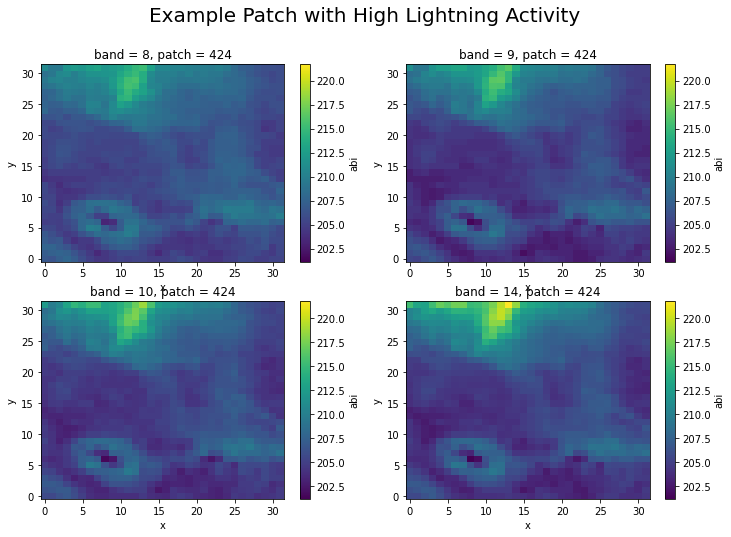

In [7]:
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts

index = high_lc_indices[205]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range  
vmax = train['abi'][index,:,:,:].max()

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Example Patch with High Lightning Activity', fontsize=20)

Areas without lightning activity often exibit a much larger BT range throughout the channel column, particularily the longwave window (Band 14) which often has much higher values with clear skies.

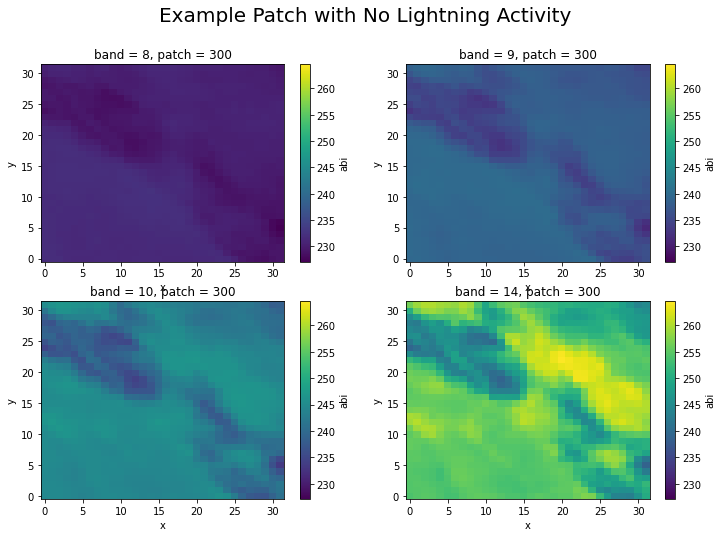

In [8]:
index = no_lc_indices[300]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range
vmax = train['abi'][index,:,:,:].max() # set min/max plotting range

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Example Patch with No Lightning Activity', fontsize=20)

This pattern is also noted when taking the mean value of each patch across the dataset.

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


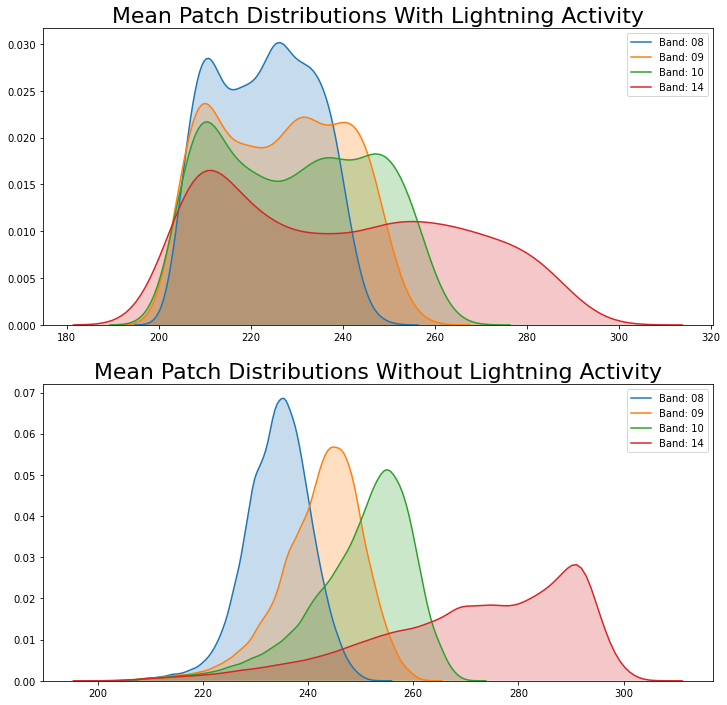

In [9]:
lc_train = train.isel(patch=high_lc_indices) # all patch data with lightning counts (above threshold)
no_lc_train = train.isel(patch=no_lc_indices) # all patch data without lightning activity
mean_patches_lc = lc_train.abi.mean(dim=('x','y')) # mean BT of each patch
mean_patches_no_lc = no_lc_train.abi.mean(dim=('x','y')) # mean BT of each patch

fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(mean_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Mean Patch Distributions With Lightning Activity', fontsize=22)
    else:
        sns.kdeplot(mean_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Mean Patch Distributions Without Lightning Activity', fontsize=22)

### Data Transforms
Discuss any transforms or normalizations that may be needed for this dataset. Remember to fit a scaler only to the training data and then apply it on testing and validation.

In [10]:
# Visual of input variable before and after transform
# Example of data transform procedure for dataset

In [11]:
%%time
# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)

# scale data
scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


CPU times: user 18 s, sys: 5.34 s, total: 23.3 s
Wall time: 23.1 s


In [12]:
# declare ResNet (residual network from the goes16i module) and list the default parameters
# Any of these parameters can be overridden
# note using larger batch sizes here can cause memory errors
resNet_mod = ResNet(epochs=5, batch_size=128)
vars(resNet_mod)

{'min_filters': 16,
 'filter_width': 3,
 'filter_growth_rate': 2,
 'min_data_width': 4,
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid',
 'use_dropout': False,
 'pooling': 'mean',
 'dropout_alpha': 0.0,
 'data_format': 'channels_last',
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'loss': 'mse',
 'metrics': None,
 'leaky_alpha': 0.1,
 'batch_size': 128,
 'epochs': 5,
 'sgd_momentum': 0.99,
 'model': None,
 'parallel_model': None,
 'time_history': <goes16ci.models.TimeHistory at 0x7f67890f5190>,
 'loss_history': <goes16ci.models.LossHistory at 0x7f67890f5750>,
 'verbose': 0}

In [13]:
%%time
# Fit model and print architecture
resNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
resNet_mod.model.summary()

{'loss': 0.0781928151845932, 'val_loss': 0.3502139449119568}
{'loss': 0.06806056946516037, 'val_loss': 0.08672213554382324}
{'loss': 0.06457312405109406, 'val_loss': 0.09555880725383759}
{'loss': 0.06225462257862091, 'val_loss': 0.08784414082765579}
{'loss': 0.06086549535393715, 'val_loss': 0.08146827667951584}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   592         scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 32, 16)   64          conv2d[0][0] 

## Baseline ResNet Evaluation Metrics
We trained on binary output data, but output probabilities before converting to class. This allows us to evaluate regressed and classified metrics:


| Type | Metric | Value to beat |
| ------------- | :----:|:-------|
|  Regressed   ||   
|              | RMSE: |0.328|
|              | R2: |0.567 |
|              | Hellenger Distance: |0.501|
|||
| Classified   |||
|              | Heidke Skill Score: |0.705|
|              | Peirce Skill Score:  |0.713|
|              | Brier Score: |0.143|
|              | Brier Skill Score: |0.402|
|              | AUC: |0.856|

In [14]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = resNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [15]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

In [16]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

RMSE: 0.285
R squared: 0.666
Hellenger Distance: 0.202
Heidke Skill Score: 0.781
Pierce Skill Score: 0.776
Brier Score: 0.104
Brier Skill Score: 0.565
AUC: 0.888


## Interpretation
Description of interpretation methods for problem

In [17]:
# Include examples of interpretation code

## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

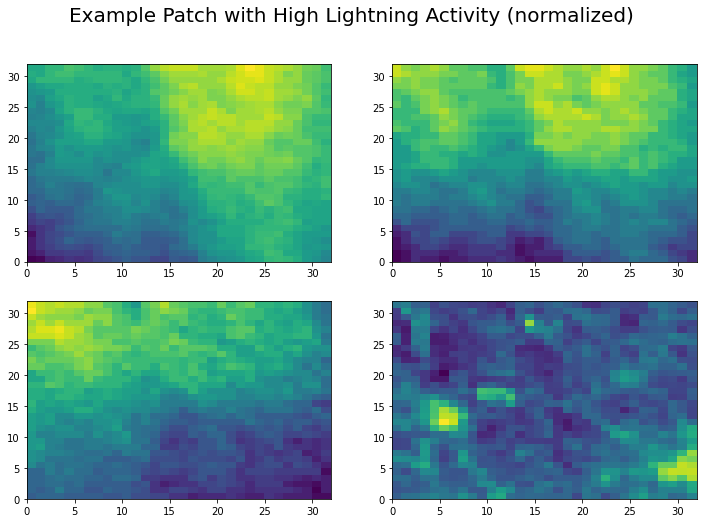

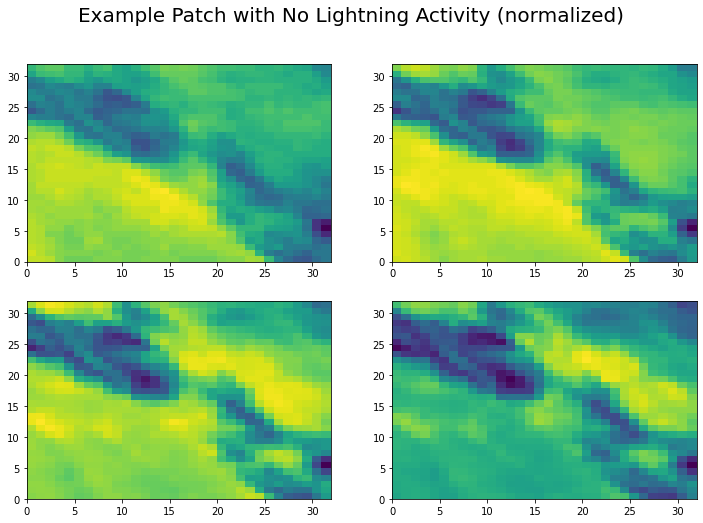

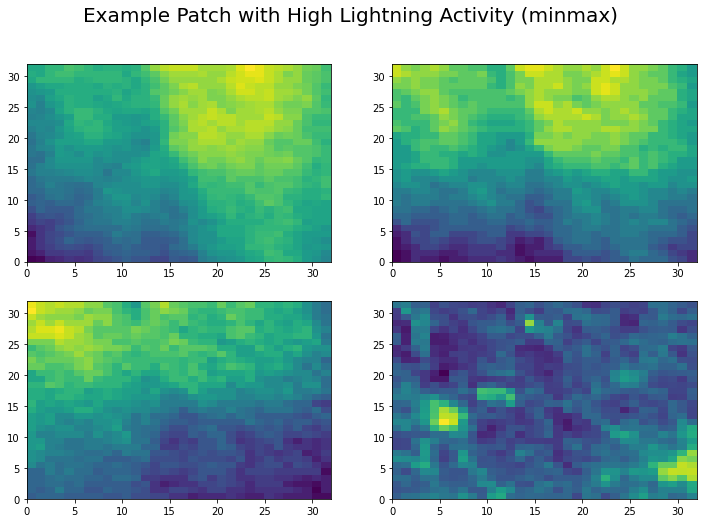

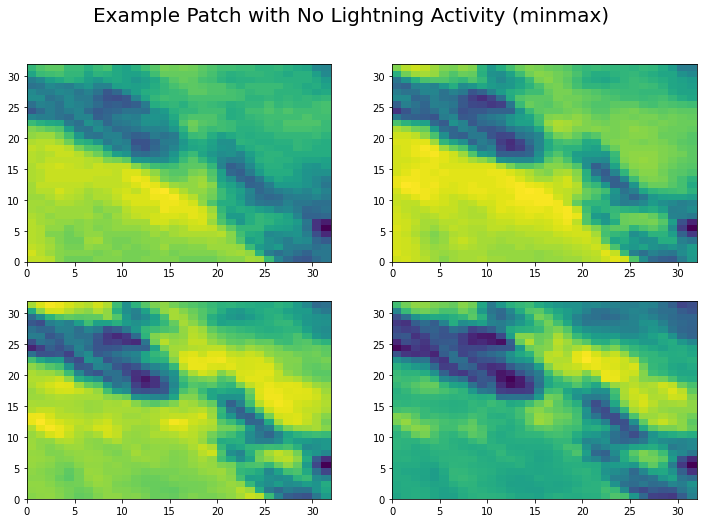

In [18]:
#Try a new scaling method and visualize that scaling method and the scaling method used in the example code
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from scipy.ndimage import gaussian_filter
#scaler = MinMaxScaler()
train_in_normalized=np.zeros(np.shape(train_in))
val_in_normalized=np.zeros(np.shape(val_in))

for k in range(4):
    mean=np.mean(train_in[:,:,:,k])
    standev=np.std(train_in[:,:,:,k])
    train_in_normalized[:,:,:,k]=(train_in[:,:,:,k]-mean)/standev
    val_in_normalized[:,:,:,k]=(val_in[:,:,:,k]-mean)/standev

index = high_lc_indices[205]
fig, ax = plt.subplots(2,2, figsize=(12,8))
plt.suptitle('Example Patch with High Lightning Activity (normalized)', fontsize=20)
ax[0,0].pcolor(train_in_normalized[index,:,:,0],
                 vmin=np.min(train_in_normalized[index,:,:,0]), 
                 vmax=np.max(train_in_normalized[index,:,:,0]))
ax[0,1].pcolor(train_in_normalized[index,:,:,1],
                 vmin=np.min(train_in_normalized[index,:,:,1]), 
                 vmax=np.max(train_in_normalized[index,:,:,1]))
ax[1,0].pcolor(train_in_normalized[index,:,:,2],
                 vmin=np.min(train_in_normalized[index,:,:,2]), 
                 vmax=np.max(train_in_normalized[index,:,:,2]))
ax[1,1].pcolor(train_in_normalized[index,:,:,3],
                 vmin=np.min(train_in_normalized[index,:,:,3]), 
                 vmax=np.max(train_in_normalized[index,:,:,3]))
index = no_lc_indices[300]

fig, ax = plt.subplots(2,2, figsize=(12,8))
plt.suptitle('Example Patch with No Lightning Activity (normalized)', fontsize=20)
ax[0,0].pcolor(train_in_normalized[index,:,:,0],
                 vmin=np.min(train_in_normalized[index,:,:,0]), 
                 vmax=np.max(train_in_normalized[index,:,:,0]))
ax[0,1].pcolor(train_in_normalized[index,:,:,1],
                 vmin=np.min(train_in_normalized[index,:,:,1]), 
                 vmax=np.max(train_in_normalized[index,:,:,1]))
ax[1,0].pcolor(train_in_normalized[index,:,:,2],
                 vmin=np.min(train_in_normalized[index,:,:,2]), 
                 vmax=np.max(train_in_normalized[index,:,:,2]))
ax[1,1].pcolor(train_in_normalized[index,:,:,3],
                 vmin=np.min(train_in_normalized[index,:,:,3]), 
                 vmax=np.max(train_in_normalized[index,:,:,3]))

index = high_lc_indices[205]
fig, ax = plt.subplots(2,2, figsize=(12,8))
plt.suptitle('Example Patch with High Lightning Activity (minmax)', fontsize=20)
ax[0,0].pcolor(scaled_train_in[index,:,:,0],
                 vmin=np.min(scaled_train_in[index,:,:,0]), 
                 vmax=np.max(scaled_train_in[index,:,:,0]))
ax[0,1].pcolor(scaled_train_in[index,:,:,1],
                 vmin=np.min(scaled_train_in[index,:,:,1]), 
                 vmax=np.max(scaled_train_in[index,:,:,1]))
ax[1,0].pcolor(scaled_train_in[index,:,:,2],
                 vmin=np.min(scaled_train_in[index,:,:,2]), 
                 vmax=np.max(scaled_train_in[index,:,:,2]))
ax[1,1].pcolor(scaled_train_in[index,:,:,3],
                 vmin=np.min(scaled_train_in[index,:,:,3]), 
                 vmax=np.max(scaled_train_in[index,:,:,3]))
index = no_lc_indices[300]
fig, ax = plt.subplots(2,2, figsize=(12,8))
plt.suptitle('Example Patch with No Lightning Activity (minmax)', fontsize=20)
ax[0,0].pcolor(scaled_train_in[index,:,:,0],
                 vmin=np.min(scaled_train_in[index,:,:,0]), 
                 vmax=np.max(scaled_train_in[index,:,:,0]))
ax[0,1].pcolor(scaled_train_in[index,:,:,1],
                 vmin=np.min(scaled_train_in[index,:,:,1]), 
                 vmax=np.max(scaled_train_in[index,:,:,1]))
ax[1,0].pcolor(scaled_train_in[index,:,:,2],
                 vmin=np.min(scaled_train_in[index,:,:,2]), 
                 vmax=np.max(scaled_train_in[index,:,:,2]))
ax[1,1].pcolor(scaled_train_in[index,:,:,3],
                 vmin=np.min(scaled_train_in[index,:,:,3]), 
                 vmax=np.max(scaled_train_in[index,:,:,3]))


Shows differences in MinMax scaling and Gaussian normalization for the full training data set

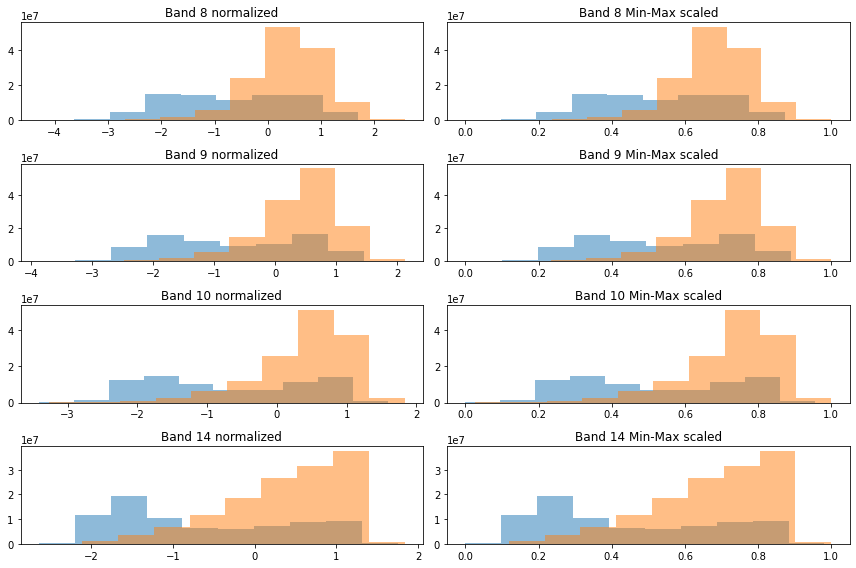

In [19]:
high_lc_indices_processed=np.where(train_out==1.0)
low_lc_indices_processed=np.where(train_out==0.0)

fig, ax = plt.subplots(4, 2, figsize=(12,8))
for band, name in zip(range(4), ['Band 8', 'Band 9', 'Band 10', 'Band 14']):
    ax[band,0].hist(train_in_normalized[high_lc_indices_processed,:,:,band].reshape(-1), alpha=0.5, label='unscaled')
    ax[band,0].hist(train_in_normalized[low_lc_indices_processed,:,:,band].reshape(-1), alpha=0.5, label='unscaled')
    ax[band,0].set_title(name + ' normalized')
    ax[band,1].hist(scaled_train_in[high_lc_indices_processed,:,:,band].reshape(-1), alpha=0.5, label='scaled');
    ax[band,1].hist(scaled_train_in[low_lc_indices_processed,:,:,band].reshape(-1), alpha=0.5, label='unscaled')
    ax[band,1].set_title(name + ' Min-Max scaled')
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


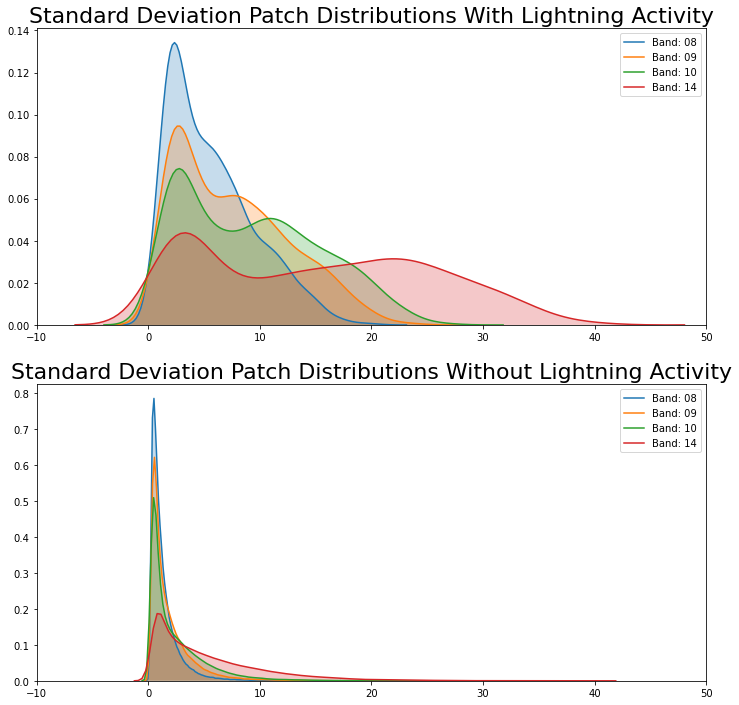

In [20]:
lc_train = train.isel(patch=high_lc_indices) # all patch data with lightning counts (above threshold)
no_lc_train = train.isel(patch=no_lc_indices) # all patch data without lightning activity
std_patches_lc = lc_train.abi.std(dim=('x','y')) # mean BT of each patch
std_patches_no_lc = no_lc_train.abi.std(dim=('x','y')) # mean BT of each patch

fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(std_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Standard Deviation Patch Distributions With Lightning Activity', fontsize=22)
        ax[0].set_xlim(-10, 50)
    else:
        sns.kdeplot(std_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Standard Deviation Patch Distributions Without Lightning Activity', fontsize=22)
        ax[1].set_xlim(-10, 50)
        
fig.savefig('std_distribution.png')

/opt/conda/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


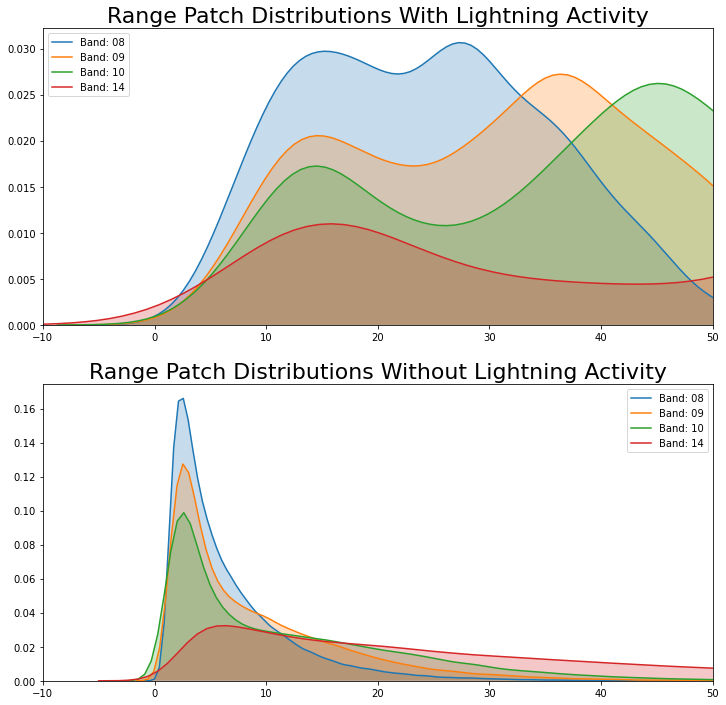

In [21]:
def patch_range(da):
    """returns range for patch by band"""
    return da.max(dim=['x','y']) - da.min(dim=['x','y'])

range_patches_lc = patch_range(lc_train.abi)
range_patches_no_lc = patch_range(no_lc_train.abi)

fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(range_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Range Patch Distributions With Lightning Activity', fontsize=22)
        ax[0].set_xlim(-10, 50)
    else:
        sns.kdeplot(range_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Range Patch Distributions Without Lightning Activity', fontsize=22)
        ax[1].set_xlim(-10, 50)
        
fig.savefig('range_distribution.png')

/opt/conda/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


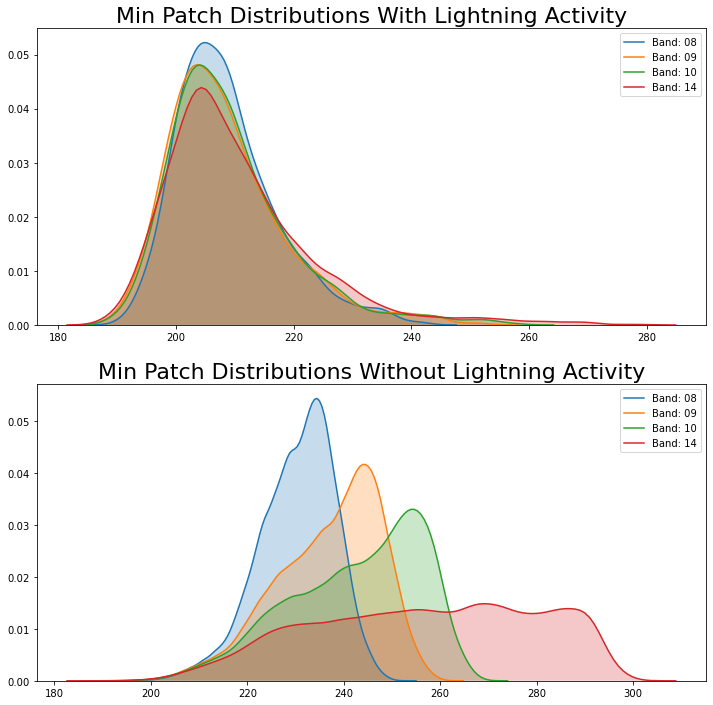

In [22]:
def patch_min(da):
    """returns range for patch by band"""
    return da.min(dim=['x','y'])

min_patches_lc = patch_min(lc_train.abi)
min_patches_no_lc = patch_min(no_lc_train.abi)

fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(min_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Min Patch Distributions With Lightning Activity', fontsize=22)
        #ax[0].set_xlim(-10, 50)
    else:
        sns.kdeplot(min_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Min Patch Distributions Without Lightning Activity', fontsize=22)
        #ax[1].set_xlim(-10, 50)
        
fig.savefig('min_distribution.png')

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


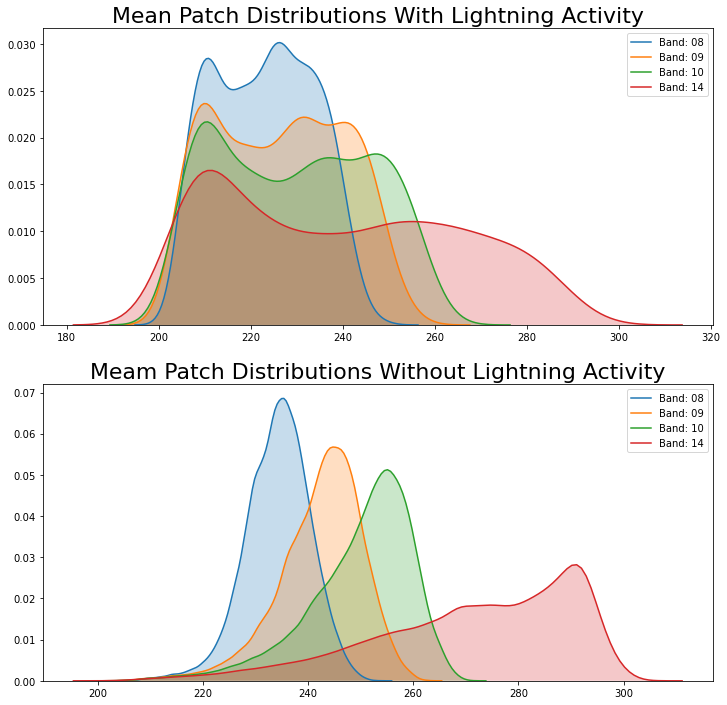

In [23]:
def patch_mean(da):
    """returns mean for patch by band"""
    return da.mean(dim=['x','y'])

max_patches_lc = patch_mean(lc_train.abi)
max_patches_no_lc = patch_mean(no_lc_train.abi)

fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(mean_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Mean Patch Distributions With Lightning Activity', fontsize=22)
        #ax[0].set_xlim(-10, 50)
    else:
        sns.kdeplot(mean_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Meam Patch Distributions Without Lightning Activity', fontsize=22)
        #ax[1].set_xlim(-10, 50)
        
fig.savefig('mean_distribution.png')

In [24]:
#Compute statistics to use for the decision tree

high_lc_indices_processed=np.where(train_out==1.0)
low_lc_indices_processed=np.where(train_out==0.0)

print(np.shape(high_lc_indices_processed))
print(np.shape(low_lc_indices_processed))

train_band_std=np.std(train_in_normalized,axis=(1,2))
train_band_min=np.min(train_in_normalized,axis=(1,2))
train_band_max=np.max(train_in_normalized,axis=(1,2))
train_band_mean=np.mean(train_in_normalized,axis=(1,2))
train_band_median=np.median(train_in_normalized,axis=(1,2))
train_band_range=train_band_max-train_band_min

val_band_std=np.std(val_in_normalized,axis=(1,2))
val_band_min=np.min(val_in_normalized,axis=(1,2))
val_band_max=np.max(val_in_normalized,axis=(1,2))
val_band_mean=np.mean(val_in_normalized,axis=(1,2))
val_band_median=np.median(val_in_normalized,axis=(1,2))
val_band_range=val_band_max-val_band_min



(1, 77612)
(1, 134992)


In [25]:
#Try using a single decision tree before going onto an ensemble

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

train_band_std=np.std(train_in_normalized,axis=(1,2))
val_band_std=np.std(val_in_normalized,axis=(1,2))

clf = DecisionTreeClassifier(random_state=0)

clf_band1 = clf.fit(train_band_std[:,0].reshape(-1,1), train_out)
band1_acc=np.shape(np.where(val_out==clf_band1.predict(val_band_std[:,0].reshape(-1,1))))[1]/np.shape(val_in_normalized)[0]
print('Success rate using just std of band 1 is ',band1_acc)

clf_band1 = clf.fit(train_band_mean[:,0].reshape(-1,1), train_out)
band1_acc=np.shape(np.where(val_out==clf_band1.predict(val_band_mean[:,0].reshape(-1,1))))[1]/np.shape(val_in_normalized)[0]
print('Success rate using just mean of band 1 is ',band1_acc)

clf_band1 = clf.fit(np.array([train_band_std[:,0],train_band_mean[:,0]]).T, train_out)
band1_acc=np.shape(np.where(val_out==clf_band1.predict(np.array([val_band_std[:,0],val_band_mean[:,0]]).T)))[1]/np.shape(val_in_normalized)[0]
print('Success rate using just mean and std of band 1 is ',band1_acc)

clf_band1 = clf.fit(np.array([train_band_std[:,0],train_band_min[:,0]]).T, train_out)
band1_acc=np.shape(np.where(val_out==clf_band1.predict(np.array([val_band_std[:,0],val_band_min[:,0]]).T)))[1]/np.shape(val_in_normalized)[0]
print('Success rate using just mean and min of band 1 is ',band1_acc)

clf_band1 = clf.fit(np.concatenate((train_band_std,train_band_mean),axis=1), train_out)
band1_acc=np.shape(np.where(val_out==clf_band1.predict(np.concatenate((val_band_std,val_band_mean),axis=1))))[1]/np.shape(val_in_normalized)[0]
print('Success rate using std and mean of all bands is ',band1_acc)

clf_band1 = clf.fit(np.concatenate((train_band_std,train_band_min),axis=1), train_out)
band1_acc=np.shape(np.where(val_out==clf_band1.predict(np.concatenate((val_band_std,val_band_min),axis=1))))[1]/np.shape(val_in_normalized)[0]
print('Success rate using std and min of all bands is ',band1_acc)

clf_band2 = clf.fit(train_band_std[:,1].reshape(-1,1), train_out)
band2_acc=np.shape(np.where(val_out==clf_band2.predict(val_band_std[:,0].reshape(-1,1))))[1]/np.shape(val_in_normalized)[0]
print('Success rate using just std of band 2 is ',band2_acc)

clf_band3 = clf.fit(train_band_std[:,2].reshape(-1,1), train_out)
band3_acc=np.shape(np.where(val_out==clf_band3.predict(val_band_std[:,0].reshape(-1,1))))[1]/np.shape(val_in_normalized)[0]
print('Success rate using just std of band 3 is ',band3_acc)

clf_band4 = clf.fit(train_band_std[:,3].reshape(-1,1), train_out)
band4_acc=np.shape(np.where(val_out==clf_band4.predict(val_band_std[:,0].reshape(-1,1))))[1]/np.shape(val_in_normalized)[0]
print('Success rate using just std of band 4 is ',band4_acc)

Success rate using just std of band 1 is  0.7016935892356532
Success rate using just mean of band 1 is  0.6708408768348888
Success rate using just mean and std of band 1 is  0.7661422574837387
Success rate using just mean and min of band 1 is  0.7770650805671041
Success rate using std and mean of all bands is  0.8098084744657696
Success rate using std and min of all bands is  0.8157764081063597
Success rate using just std of band 2 is  0.6895019533698765
Success rate using just std of band 3 is  0.6728168145276556
Success rate using just std of band 4 is  0.6449982196500484


In [26]:
#Define metrics for evaluating our algorithms

from sklearn.metrics import confusion_matrix

def precision(conf_mtx):
    """Returns precision metric"""
    return conf_mtx[1,1] / (conf_mtx[1,1]+conf_mtx[0,1])
def recall(conf_mtx):
    """Returns recall metric"""
    return conf_mtx[1,1] / (conf_mtx[1,1]+conf_mtx[1,0])
def accuracy(conf_mtx):
    """Returns accuracy"""
    return (conf_mtx[1,1]+conf_mtx[0,0])/conf_mtx.sum()
def f1(conf_mtx):
    """Returns f1"""
    return 2*precision(conf_mtx)*recall(conf_mtx)/(precision(conf_mtx)+recall(conf_mtx))


In [27]:
#Try a random forest using the standard deviation of each band

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import scipy

clf = RandomForestClassifier()
    
clf_std = clf.fit(train_band_std, train_out)
val_pred = clf_std.predict(val_band_std)

cm = confusion_matrix(val_out, val_pred)

print(cm)

print('Using random forest with the standard deviation of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 

clf_std = clf.fit(np.concatenate((train_band_std,train_band_mean),axis=1), train_out)
val_pred = clf_std.predict(np.concatenate((val_band_std,val_band_mean),axis=1))

cm = confusion_matrix(val_out, val_pred)

print('Using random forest with the standard deviation and mean of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 

#print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, val_preds),3)))
#print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, val_preds),3)))
#print('Brier Score: {}'.format(np.round(brier_score(val_out, val_preds),3)))
#print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, val_preds),3)))
#print('AUC: {}'.format(np.round(roc_auc_score(val_out, val_preds),3)))

clf_std = clf.fit(np.concatenate((train_band_std,train_band_max),axis=1), train_out)
val_pred = clf_std.predict(np.concatenate((val_band_std,val_band_max),axis=1))

cm = confusion_matrix(val_out, val_pred)

print('Using random forest with the standard deviation and max of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 

clf_std = clf.fit(np.concatenate((train_band_std,train_band_min),axis=1), train_out)
val_pred = clf_std.predict(np.concatenate((val_band_std,val_band_min),axis=1))

cm = confusion_matrix(val_out, val_pred)

print('Using random forest with the standard deviation and min of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 

clf_std = clf.fit(np.concatenate((train_band_std,train_band_range),axis=1), train_out)
val_pred = clf_std.predict(np.concatenate((val_band_std,val_band_range),axis=1))

cm = confusion_matrix(val_out, val_pred)

print('Using random forest with the standard deviation and range of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 

clf = GradientBoostingClassifier()
    
clf_std = clf.fit(train_band_std, train_out)
val_pred = clf_std.predict(val_band_std)

cm = confusion_matrix(val_out, val_pred)

print('Using gradient boosted trees with the standard deviation of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 


[[104300  16300]
 [ 16305  62494]]
Using random forest with the standard deviation of all bands, 
Accuracy 0.8364836333181209,  Precision 0.7931314567099018, Recall 0.7930811304711989, F1 0.7931062927921925
Using random forest with the standard deviation and mean of all bands, 
Accuracy 0.8649391421220768,  Precision 0.8317810812885398, Recall 0.8250993032906508, F1 0.8284267193323352
Using random forest with the standard deviation and max of all bands, 
Accuracy 0.8542720876233081,  Precision 0.8168983575642512, Recall 0.813601695452988, F1 0.8152466937945066
Using random forest with the standard deviation and min of all bands, 
Accuracy 0.8708970456220944,  Precision 0.8405741282801829, Recall 0.8308988692749908, F1 0.8357084963399302
Using random forest with the standard deviation and range of all bands, 
Accuracy 0.8614235778514436,  Precision 0.8260249009188108, Recall 0.8225865810479829, F1 0.8243021555287086
Using gradient boosted trees with the standard deviation of all bands, 

In [28]:
train_std_min_range=np.concatenate((np.concatenate((train_band_std,train_band_min),axis=1),train_band_range),axis=1)
val_std_min_range=np.concatenate((np.concatenate((val_band_std,val_band_min),axis=1),val_band_range),axis=1)

clf = RandomForestClassifier()

clf_std = clf.fit(train_std_min_range, train_out)
val_pred = clf_std.predict(val_std_min_range)

cm = confusion_matrix(val_out, val_pred)

print('Using random forest with the standard deviation, min, and range of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 

train_std_min_mean=np.concatenate((np.concatenate((train_band_std,train_band_min),axis=1),train_band_mean),axis=1)
val_std_min_mean=np.concatenate((np.concatenate((val_band_std,val_band_min),axis=1),val_band_mean),axis=1)

clf_std = clf.fit(train_std_min_mean, train_out)
val_pred = clf_std.predict(val_std_min_mean)

cm = confusion_matrix(val_out, val_pred)

print('Using random forest with the standard deviation, min, and mean of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 


KeyboardInterrupt: 

In [ ]:
#Try PCA for dimensionality reduction

from sklearn.decomposition import PCA
#n_comps=1
#X_transformed=np.zeros((np.shape(train_in_normalized)[0],32,n_comps))
#pca = PCA(n_components=n_comps)
#for i in range(np.shape(train_in_normalized)[0]):
#    for j in range(4):
#        pca.fit(train_in_normalized[i,:,:,j])
#        X_transformed[i,:,:] = pca.fit_transform(train_in_normalized[i,:,:,j])

index = high_lc_indices[205]
pca = PCA(n_components=5)     

fig, ax = plt.subplots(2,2, figsize=(12,8))
plt.suptitle('Example Patch with High Lightning Activity (PCA reconstruction)', fontsize=20)
lightning_transformed=pca.fit_transform(train_in_normalized[index,:,:,0])
proj = pca.inverse_transform(lightning_transformed)
ax[0,0].pcolor(proj,vmin=np.min(proj),vmax=np.max(proj))
lightning_transformed=pca.fit_transform(train_in_normalized[index,:,:,1])
proj = pca.inverse_transform(lightning_transformed)
ax[0,1].pcolor(proj,vmin=np.min(proj),vmax=np.max(proj))
lightning_transformed=pca.fit_transform(train_in_normalized[index,:,:,2])
proj = pca.inverse_transform(lightning_transformed)
ax[1,0].pcolor(proj,vmin=np.min(proj),vmax=np.max(proj))
lightning_transformed=pca.fit_transform(train_in_normalized[index,:,:,3])
proj = pca.inverse_transform(lightning_transformed)
ax[1,1].pcolor(proj,vmin=np.min(proj),vmax=np.max(proj))

index = no_lc_indices[300]
fig, ax = plt.subplots(2,2, figsize=(12,8))
plt.suptitle('Example Patch with No Lightning Activity (PCA reconstruction)', fontsize=20)
lightning_transformed=pca.fit_transform(train_in_normalized[index,:,:,0])
proj = pca.inverse_transform(lightning_transformed)
ax[0,0].pcolor(proj,vmin=np.min(proj),vmax=np.max(proj))
lightning_transformed=pca.fit_transform(train_in_normalized[index,:,:,1])
proj = pca.inverse_transform(lightning_transformed)
ax[0,1].pcolor(proj,vmin=np.min(proj),vmax=np.max(proj))
lightning_transformed=pca.fit_transform(train_in_normalized[index,:,:,2])
proj = pca.inverse_transform(lightning_transformed)
ax[1,0].pcolor(proj,vmin=np.min(proj),vmax=np.max(proj))
lightning_transformed=pca.fit_transform(train_in_normalized[index,:,:,3])
proj = pca.inverse_transform(lightning_transformed)
ax[1,1].pcolor(proj,vmin=np.min(proj),vmax=np.max(proj))


### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

In [ ]:
# Tuesday's code goes here

#Use geos16ci for NN

from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D

StandardConvNet_mod = StandardConvNet(epochs=5, batch_size=128)
vars(StandardConvNet_mod)

StandardConvNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
StandardConvNet_mod.model.summary()


{'loss': 0.10395154356956482, 'val_loss': 0.0975085198879242}
{'loss': 0.08592221140861511, 'val_loss': 0.09311099350452423}
{'loss': 0.08099183440208435, 'val_loss': 0.09664839506149292}
{'loss': 0.07808995246887207, 'val_loss': 0.08484400808811188}


In [ ]:
#Compute the same metrics for the NN as we did for the decision trees

import timeit

def predict_model():
    val_pred = StandardConvNet_mod.predict(scaled_val_in)

prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)
    
print(prediction_time)
    
pred_conv = StandardConvNet_mod.predict(scaled_val_in)
val_out_conv_binary=np.zeros(np.shape(vpred_conv))
val_out_conv_binary[np.where(val_out_conv>.5)]=1

def predict_model():
    val_pred = ResNet_mod.predict(scaled_val_in)

prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

print(prediction_time)

pred_resnet = ResNet_mod.predict(scaled_val_in)
val_out_resnet_binary=np.zeros(np.shape(val_out_resnet))
val_out_resnet_binary[np.where(val_out_resnet>.5)]=1

cm = confusion_matrix(val_out, val_out_resnet_binary)

print('Metrics using resnet are ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 

cm = confusion_matrix(val_out, val_out_conv_binary)

print('Metrics using convnet are ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 

The code below sets up and trains a Convolutional Neural Network.  I have experimented with adjusting filter width and pooling.  A filter width of 1 was used to simulate a 1x1 dense network.  Filter sizes of 5 and 9 were also tried.  Pooling methods Max and Mean were also used.  The results are below.

In [ ]:
%%time
ConvNet_mod = StandardConvNet(epochs=10, batch_size=100, filter_width=9, pooling='mean')
# Fit model and print architecture
ConvNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
print(ConvNet_mod.model.summary())



In [ ]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = ConvNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [ ]:
# Example regressed metrics
print(f'Filter width: {ConvNet_mod.filter_width}')
print(f'Pooling: {ConvNet_mod.pooling}')
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [ ]:
# Wednesday's code goes here



In [ ]:
#Compare different model architectures with the same features and do hyperparameter tuning

train_std_min=np.concatenate((train_band_std,train_band_min),axis=1)
val_std_min=np.concatenate((val_band_std,val_band_min),axis=1)

train_std_min_mean=np.concatenate((np.concatenate((train_band_std,train_band_min),axis=1),train_band_mean),axis=1)
val_std_min_mean=np.concatenate((np.concatenate((val_band_std,val_band_min),axis=1),val_band_mean),axis=1)

import timeit

#Single decision tree

#BASELINE
print('BASELINE')

clf = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='best',max_depth=None,min_samples_split=2,min_samples_leaf=1)
    
def train_model():
    clf_std = clf.fit(train_std_min, train_out)
clf_std = clf.fit(train_std_min, train_out)
def predict_model():
    val_pred = clf_std.predict(val_std_min)
val_pred = clf_std.predict(val_std_min)

training_time=timeit.timeit("train_model()", setup="from __main__ import train_model",number=1)
prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

cm = confusion_matrix(val_out, val_pred)

print('Using single decision tree with the standard deviation and min of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 
print(f"Training time {training_time}, Prediction Time {prediction_time}")

def train_model():
    clf_std = clf.fit(train_std_min_mean, train_out)
clf_std = clf.fit(train_std_min_mean, train_out)
def predict_model():
    val_pred = clf_std.predict(val_std_min_mean)
val_pred = clf_std.predict(val_std_min_mean)

training_time=timeit.timeit("train_model()", setup="from __main__ import train_model",number=1)
prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

cm = confusion_matrix(val_out, val_pred)

print('Using single decision tree with the standard deviation, min, and mean of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 
print(f"Training time {training_time}, Prediction Time {prediction_time}")

#WITH SOME HYPERPARAMETER TUNING
print('OPTIMIZE HYPERPARAMETERS')
print('We can get a substantial performance boost from increasing min_samples_leaf')
clf = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='best',max_depth=None,min_samples_split=4,min_samples_leaf=100)

def train_model():
    clf_std = clf.fit(train_std_min, train_out)
clf_std = clf.fit(train_std_min, train_out)
def predict_model():
    val_pred = clf_std.predict(val_std_min)
val_pred = clf_std.predict(val_std_min)

training_time=timeit.timeit("train_model()", setup="from __main__ import train_model",number=1)
prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

cm = confusion_matrix(val_out, val_pred)

print('Using single decision tree with the standard deviation and min of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 
print(f"Training time {training_time}, Prediction Time {prediction_time}")

def train_model():
    clf_std = clf.fit(train_std_min_mean, train_out)
clf_std = clf.fit(train_std_min_mean, train_out)
def predict_model():
    val_pred = clf_std.predict(val_std_min_mean)
val_pred = clf_std.predict(val_std_min_mean)

training_time=timeit.timeit("train_model()", setup="from __main__ import train_model",number=1)
prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

cm = confusion_matrix(val_out, val_pred)

print('Using single decision tree with the standard deviation, min, and mean of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 
print(f"Training time {training_time}, Prediction Time {prediction_time}")

In [ ]:
#Random Forest

#BASELINE
print('BASELINE')
clf = RandomForestClassifier(n_estimators=100,random_state=0,criterion='gini',max_depth=None,min_samples_split=2,min_samples_leaf=1)

def train_model():
    clf_std = clf.fit(train_std_min, train_out)
clf_std = clf.fit(train_std_min, train_out)
def predict_model():
    val_pred = clf_std.predict(val_std_min)
val_pred = clf_std.predict(val_std_min)

training_time=timeit.timeit("train_model()", setup="from __main__ import train_model",number=1)
prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

cm = confusion_matrix(val_out, val_pred)

print('Using random forest with the standard deviation and min of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 
print(f"Training time {training_time}, Prediction Time {prediction_time}")

def train_model():
    clf_std = clf.fit(train_std_min_mean, train_out)
clf_std = clf.fit(train_std_min_mean, train_out)
def predict_model():
    val_pred = clf_std.predict(val_std_min_mean)
val_pred = clf_std.predict(val_std_min_mean)

training_time=timeit.timeit("train_model()", setup="from __main__ import train_model",number=1)
prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

cm = confusion_matrix(val_out, val_pred)

print('Using random forest with the standard deviation, min, and mean of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 
print(f"Training time {training_time}, Prediction Time {prediction_time}")


In [ ]:
#WITH SOME HYPERPARAMETER TUNING
print('OPTIMIZE HYPERPARAMETERS')
print('Achieve the same accuracy with fewer trees to improve efficient')

clf = RandomForestClassifier(n_estimators=10,random_state=0,criterion='entropy',max_depth=None,min_samples_split=4,min_samples_leaf=10)

def train_model():
    clf_std = clf.fit(train_std_min, train_out)
clf_std = clf.fit(train_std_min, train_out)
def predict_model():
    val_pred = clf_std.predict(val_std_min)
val_pred = clf_std.predict(val_std_min)

training_time=timeit.timeit("train_model()", setup="from __main__ import train_model",number=1)
prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

cm = confusion_matrix(val_out, val_pred)

print('Using random forest with the standard deviation and min of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 
print(f"Training time {training_time}, Prediction Time {prediction_time}")

def train_model():
    clf_std = clf.fit(train_std_min_mean, train_out)
clf_std = clf.fit(train_std_min_mean, train_out)
def predict_model():
    val_pred = clf_std.predict(val_std_min_mean)
val_pred = clf_std.predict(val_std_min_mean)

training_time=timeit.timeit("train_model()", setup="from __main__ import train_model",number=1)
prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

cm = confusion_matrix(val_out, val_pred)

print('Using random forest with the standard deviation, min, and mean of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 
print(f"Training time {training_time}, Prediction Time {prediction_time}")


In [ ]:
#Gradient boosted tree

#BASELINE
print('BASELINE')

clf = GradientBoostingClassifier(loss='deviance',learning_rate=.1,n_estimators=100,subsample=1,criterion='friedman_mse',min_samples_split=2,min_samples_leaf=1)

def train_model():
    clf_std = clf.fit(train_std_min, train_out)
clf_std = clf.fit(train_std_min, train_out)
def predict_model():
    val_pred = clf_std.predict(val_std_min)
val_pred = clf_std.predict(val_std_min)

training_time=timeit.timeit("train_model()", setup="from __main__ import train_model",number=1)
prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

cm = confusion_matrix(val_out, val_pred)

print('Using gradient boosted trees with the standard deviation and min of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 
print(f"Training time {training_time}, Prediction Time {prediction_time}")

def train_model():
    clf_std = clf.fit(train_std_min_mean, train_out)
clf_std = clf.fit(train_std_min_mean, train_out)
def predict_model():
    val_pred = clf_std.predict(val_std_min_mean)
val_pred = clf_std.predict(val_std_min_mean)

training_time=timeit.timeit("train_model()", setup="from __main__ import train_model",number=1)
prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

cm = confusion_matrix(val_out, val_pred)

print('Using gradient boosted trees with the standard deviation, min, and mean of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 
print(f"Training time {training_time}, Prediction Time {prediction_time}")


In [ ]:
#WITH SOME HYPERPARAMETER TUNING
print('OPTIMIZE HYPERPARAMETERS')
print('I have not yet achieved a significant accuracy or efficiency boost by tuning')

clf = GradientBoostingClassifier(loss='deviance',learning_rate=.2,n_estimators=100,subsample=1,criterion='friedman_mse',min_samples_split=2,min_samples_leaf=1)

def train_model():
    clf_std = clf.fit(train_std_min, train_out)
clf_std = clf.fit(train_std_min, train_out)
def predict_model():
    val_pred = clf_std.predict(val_std_min)
val_pred = clf_std.predict(val_std_min)

training_time=timeit.timeit("train_model()", setup="from __main__ import train_model",number=1)
prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

cm = confusion_matrix(val_out, val_pred)

print('Using gradient boosted trees with the standard deviation and min of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 
print(f"Training time {training_time}, Prediction Time {prediction_time}")

def train_model():
    clf_std = clf.fit(train_std_min_mean, train_out)
clf_std = clf.fit(train_std_min_mean, train_out)
def predict_model():
    val_pred = clf_std.predict(val_std_min_mean)
val_pred = clf_std.predict(val_std_min_mean)

training_time=timeit.timeit("train_model()", setup="from __main__ import train_model",number=1)
prediction_time=timeit.timeit("predict_model()", setup="from __main__ import predict_model",number=1)

cm = confusion_matrix(val_out, val_pred)

print('Using gradient boosted trees with the standard deviation, min, and mean of all bands, ')
print(f"Accuracy {accuracy(cm)},  Precision {precision(cm)}, Recall {recall(cm)}, F1 {f1(cm)}") 
print(f"Training time {training_time}, Prediction Time {prediction_time}")

Comparison of classified metrics, training time and prediction time between 
different models.  The decision trees in this table use the standard deviation and minimum value of each band:


| Model | Training Time (s) | Prediction Time (s) | Accuracy | Precision | Recall |F1-score|
| ------------- |-------|--------|--------|--------|---------|--------|
|  ||||||
| Single decision tree (default hyperparameters): | 2.630 | 0.047 | 0.816 | 0.774 | 0.754 | 0.764 |
| Single decision tree (tuned hyperparameters): | 2.786 | 0.026 | 0.867 | 0.829 |  0.835 | 0.832 |
| Random Forest (default hyperparameters) | 46.428 | 4.608 | 0.871 | 0.840 | 0.831 | 0.835 | 
| Random Forest (tuned hyperparameters) | 6.194 | 0.370 | 0.871 | 0.836 | 0.838 | 0.837 | 
| Gradient Boosted Trees (default hyperparameters) | 57.651 | 0.290 | 0.865 | 0.830 | 0.830 | 0.830 |
| Gradient Boosted Trees (tuned hyperparameters) | 62.111 | 0.234 | 0.870 | 0.830 | 0.844 | 0.837 | 
| ResNet (default hyperparameters) | | | 0.878 | 0.829 | 0.870 | 0.849 |
| ConvNet (default hyperparameters) | 
| ConvNet (tuned hyperparameters) | | | 0.883 | 0.846 | 0.862 | 0.854 |

Comparison of classified metrics, training time and prediction time between 
different models.  The decision trees in this table use the standard deviation, minimum value, and mean value, of each band:



```
Filter width: 5
Pooling: Average
RMSE: 0.317
R squared: 0.619
Hellenger Distance: 0.621
Heidke Skill Score: 0.746
Pierce Skill Score: 0.756
Brier Score: 0.123
Brier Skill Score: 0.484
AUC: 0.878

--------------------------

Filter width: 1
Pooling: Average
RMSE: 0.366
R squared: 0.464
Hellenger Distance: 0.518
Heidke Skill Score: 0.654
Pierce Skill Score: 0.642
Brier Score: 0.162
Brier Skill Score: 0.322
AUC: 0.821
# Slightly worse AUC and Brier SS
---------------------------

Filter width: 5
Pooling: Max
RMSE: 0.305
R squared: 0.638
Hellenger Distance: 0.6
Heidke Skill Score: 0.744
Pierce Skill Score: 0.763
Brier Score: 0.125
Brier Skill Score: 0.476
AUC: 0.882
# Better than using average pooling 
------------------------------------

Filter width: 9
Pooling: max
RMSE: 0.306
R squared: 0.624
Hellenger Distance: 0.496
Heidke Skill Score: 0.737
Pierce Skill Score: 0.752
Brier Score: 0.128
Brier Skill Score: 0.463
AUC: 0.876
---------------------------------

Filter width: 9
Pooling: mean
RMSE: 0.3
R squared: 0.632
Hellenger Distance: 0.464
Heidke Skill Score: 0.748
Pierce Skill Score: 0.759
Brier Score: 0.122
Brier Skill Score: 0.489
AUC: 0.879
```

### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

In [ ]:
# Thursday's code goes here


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.